<center><h1>Khatri_Surbhi_HW6</h1></center>

Name: Surbhi Khatri
<br>
Github Username: surbhikhatri
<br>
USC ID: 9893833133

## 1. Tree-Based Methods

Import packages

In [83]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


import math
import warnings

warnings.filterwarnings("ignore")

### (a) Download the APS Failure data

In [84]:
# checked the dataset is has 20 rows of text before the main csv content
df_train = pd.read_csv("./../data/hw6/aps_failure_training_set.csv", skiprows=20, na_values='na')
df_test = pd.read_csv("./../data/hw6/aps_failure_test_set.csv", skiprows=20, na_values='na')


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Usually we can use mean, mode, median and KNN etc to deal with missing data. I'll use mean for this assignment

In [85]:
df_train["class"] = [1 if item == "pos" else 0 for item in df_train["class"]]
df_test["class"] = [1 if item == "pos" else 0 for item in df_test["class"]]
# print(df_train["class"])

In [86]:
# using mean to impute the missing data
imputer = SimpleImputer( strategy='mean')
df_train[df_train.columns[1:]] = pd.DataFrame(imputer.fit_transform(df_train[df_train.columns[1:]]))
df_test[df_test.columns[1:]] = pd.DataFrame(imputer.fit_transform(df_test[df_test.columns[1:]]))

#### (ii) Calculate the coefficient of variation

In [87]:
# cv = s/m, s = std dev. m = mean
cv = lambda x: np.std(x, ddof=1) / np.mean(x)
df = pd.concat([df_train, df_test])
# apply cv (exclude class vairbale)
cv_val = df[df.columns[1:]].apply(cv)
print("coefficient of variation:")
print(cv_val)

coefficient of variation:
aa_000      4.328608
ab_000      2.178397
ac_000      2.167648
ad_000    206.786809
ae_000     22.293998
             ...    
ee_007      4.885086
ee_008      3.335019
ee_009      5.753917
ef_000     47.925135
eg_000     45.648516
Length: 170, dtype: float64


#### (iii) Plot a correlation matrix

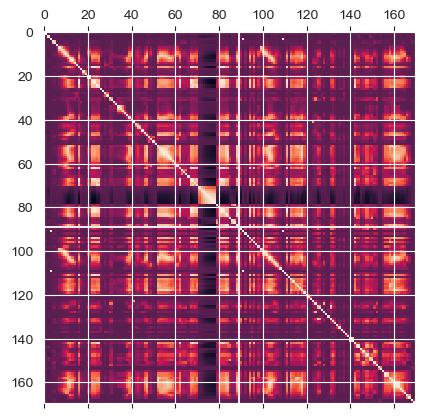

In [88]:
correlationMat = df[df.columns[1:]].corr()
plt.matshow(correlationMat)
plt.show()
# print(correlationMat)

#### (iv) Make scatter plots and box plots

In [89]:
# similar to assignment 5, using same code
c = math.floor(math.sqrt(170))
cv_val.sort_values(ascending=False, inplace=True)
cv_val = cv_val[ : c]
print(cv_val)
print("Top floor(sqrt(170)) features are:")
print(cv_val.index)

cf_000    207.335930
co_000    206.941549
ad_000    206.786809
cs_009    192.498194
dj_000    122.169994
as_000    113.895899
dh_000    112.666588
df_000    111.279258
ag_000     91.465520
au_000     86.090347
ak_000     78.624114
az_009     78.005605
ay_009     77.461293
dtype: float64
Top floor(sqrt(170)) features are:
Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'as_000', 'dh_000',
       'df_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009'],
      dtype='object')


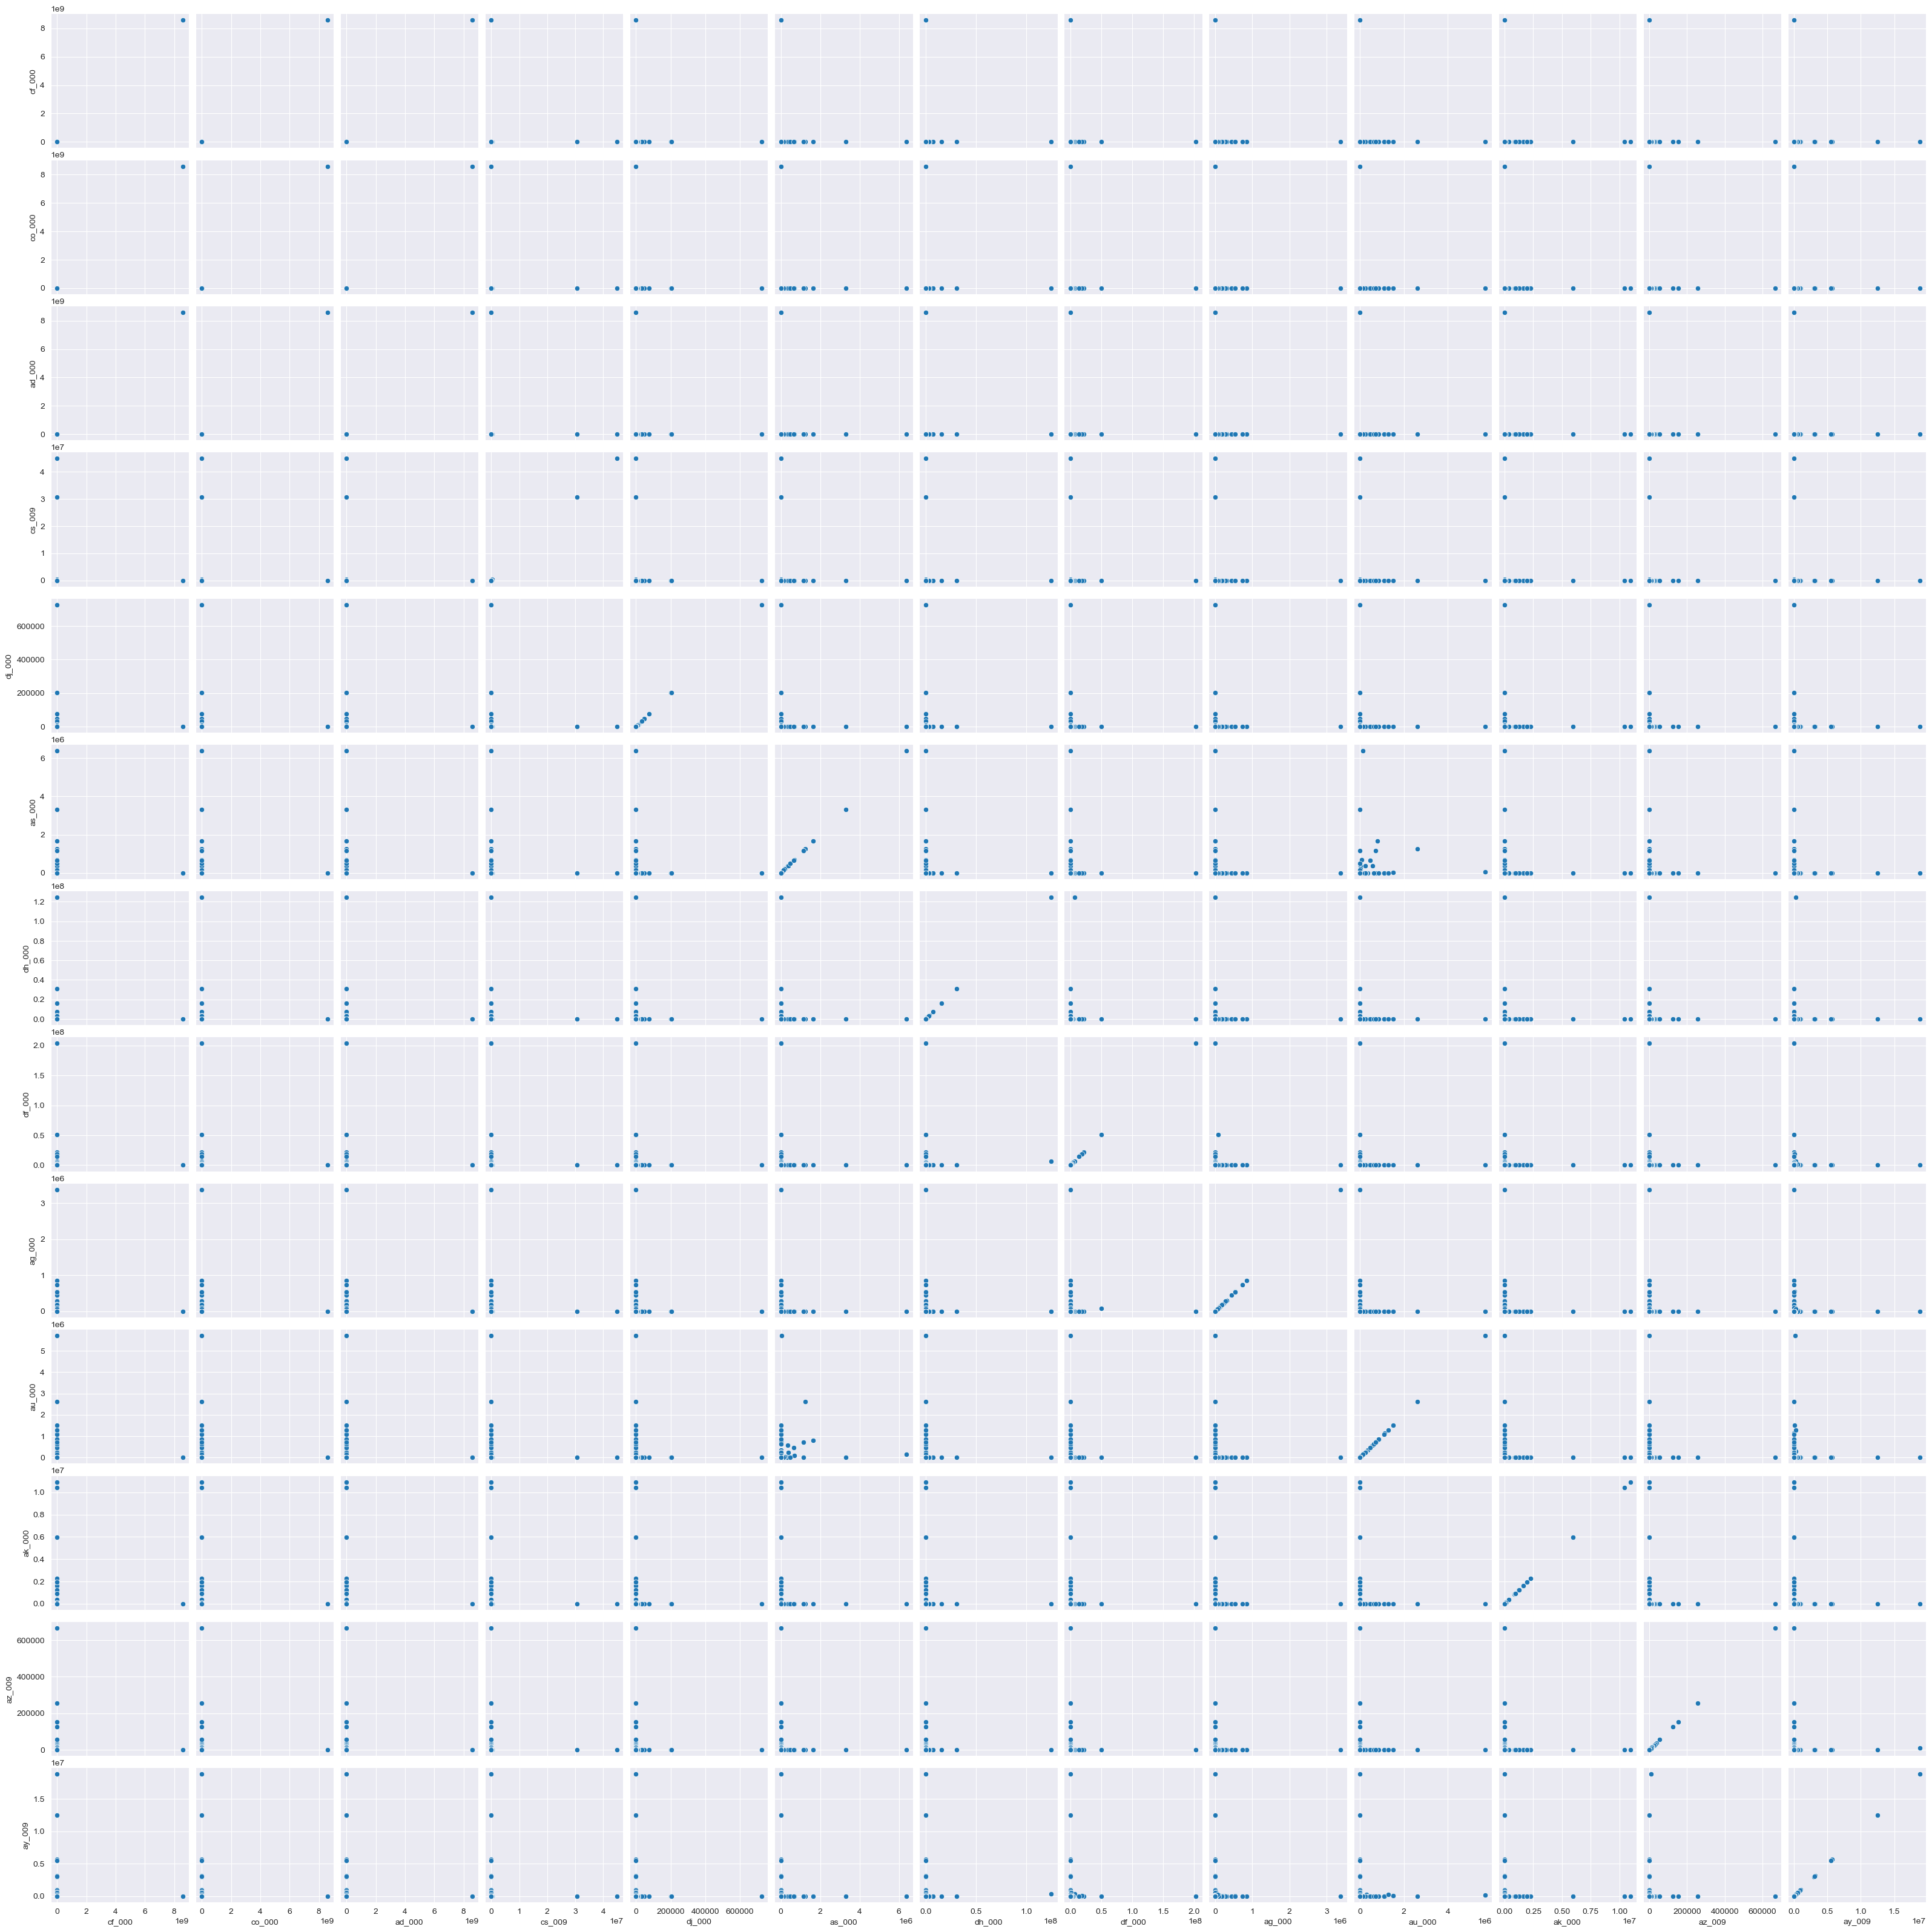

In [90]:
# pair wise scatter plot - similar to assignment 5
temp_df = df[cv_val.index]
sns.pairplot(temp_df, diag_kind=None)

[]

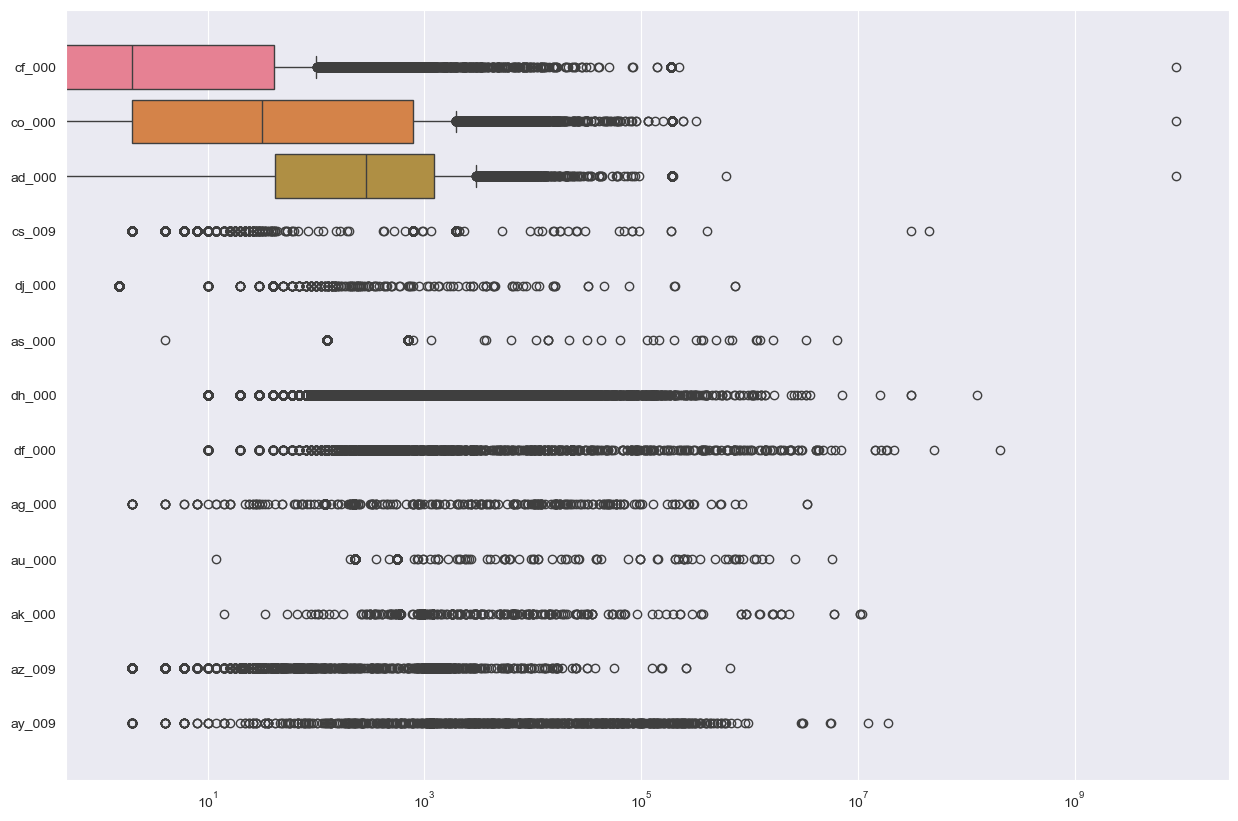

In [91]:
# box ploys
fig, axes = plt.subplots(figsize=(15, 10))
box = sns.boxplot(data=temp_df, ax=axes, orient='h')
# using log to scale data points
box.set(xscale="log")
plt.plot()

No, we can not draw conclusions about significance of those features, just by the scatter plots

#### (v) Is this data set imbalanced?

Yes, as mentioned in the problem statement 1 (a), the training set contains 60,000 rows, of which 1,000 belong to the positive. Highly imbalanced data

### (c) Train a random forest

In [92]:
# use random forest classifier: confusion matrix, ROC, AUC, mis classification for training and test set, Bag of error

rfc = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rfc.fit(df_train[df_train.columns[1:]], df_train["class"])

# predict train error
y_pred_train = rfc.predict(df_train[df_train.columns[1:]])
print("oob error: ", 1 - rfc.oob_score_)
print("Test error: ", 1 - rfc.score(df_test[df_test.columns[1:]], df_test["class"]))


oob error:  0.00605
Test error:  0.007687499999999958


Confusion Matrix - training:
 [[59000     0]
 [    1   999]]


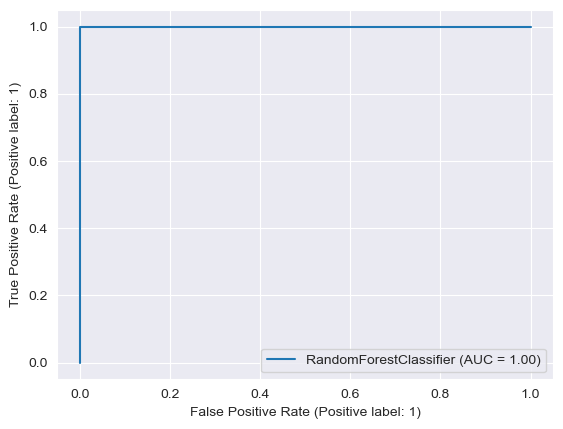

In [93]:
confusion_mat_train = confusion_matrix(df_train["class"], y_pred_train)
print("Confusion Matrix - training:\n", confusion_mat_train)
RocCurveDisplay.from_estimator(rfc, df_train[df_train.columns[1:]], df_train["class"])

Confusion Matrix - test
[[15605    20]
 [  103   272]]


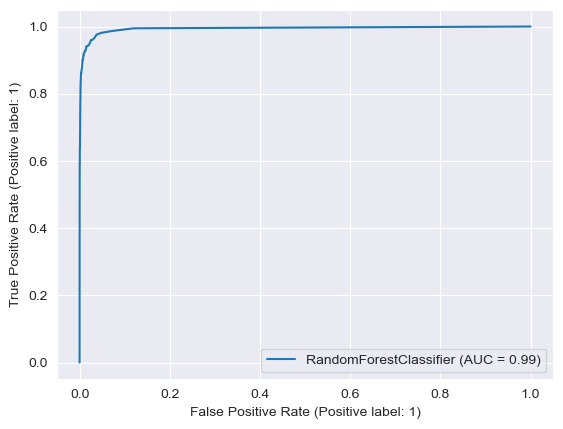

In [94]:
# test
y_pred_test = rfc.predict(df_test[df_test.columns[1:]])
confusion_mat_test = confusion_matrix(df_test["class"], y_pred_test)
print("Confusion Matrix - test")
print(confusion_mat_test)
RocCurveDisplay.from_estimator(rfc, df_test[df_test.columns[1:]], df_test["class"])

### (d) Research class imbalance in random forest

oob_error:  0.007683333333333375
Train error:  1.666666666666483e-05
Confusion Matrix - training:
 [[59000     0]
 [    1   999]]


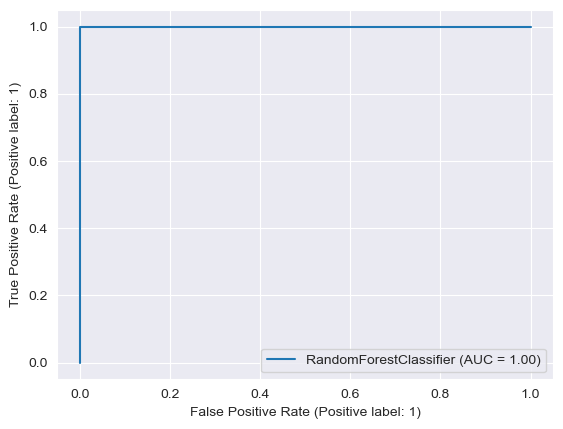

In [95]:
# use rfc to balance the dataset
rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', oob_score=True)
rfc.fit(df_train[df_train.columns[1:]], df_train["class"])


# Make test and train preds similar to 1c and compare
y_pred_train = rfc.predict(df_train[df_train.columns[1:]])
y_pred_test = rfc.predict(df_test[df_test.columns[1:]])
print("oob_error: ", 1 - rfc.oob_score_)
print("Train error: ", 1 - rfc.score(df_train[df_train.columns[1:]], df_train["class"]))

# confusion matrix for train
confusion_mat_train = confusion_matrix(df_train["class"], y_pred_train)
print("Confusion Matrix - training:\n", confusion_mat_train)
RocCurveDisplay.from_estimator(rfc, df_train[df_train.columns[1:]], df_train["class"])

Test error: 0.011499999999999955
Confusion Matrix - test
[[15612    13]
 [  171   204]]


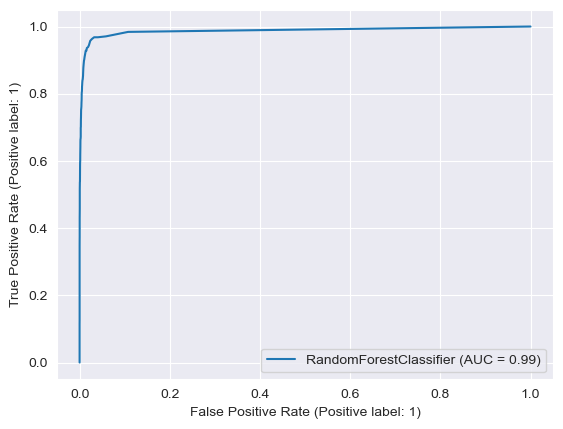

In [96]:
print("Test error:", 1 - rfc.score(df_test[df_test.columns[1:]], df_test["class"]))
# confusion matrix for test
confusion_mat_test = confusion_matrix(df_test["class"], y_pred_test)
print("Confusion Matrix - test")
print(confusion_mat_test)
RocCurveDisplay.from_estimator(rfc, df_test[df_test.columns[1:]], df_test["class"])

Pretty similar performance when using imbalanced and balanced class

### (e) XGBoost and Model Trees

In [97]:
# You can use XGBoost to fit the model tree. Determin α (the regularization term) using cross-validation
cv_errors = []
# similar to assignment 5
a = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
for alpha in a:
    print(alpha)
    params = {'objective': 'binary:logistic', 'alpha': alpha}
    # to extract features from training data set used buy xgboost
    dm_train = xgb.DMatrix(df_train[df_train.columns[1:]], label=df_train["class"])
    xgb_model = xgb.train(params, dm_train)
    output = xgb.cv(params, dm_train, nfold=5, metrics={"error"}, seed=0, callbacks=[])
    print("cv mean error:", np.mean(output["test-error-mean"]))
    cv_errors.append(np.mean(output["test-error-mean"]))

0.0001
cv mean error: 0.008639999999999998
0.001
cv mean error: 0.008643333333333333
0.01
cv mean error: 0.008591666666666668
0.1
cv mean error: 0.008453333333333334
1
cv mean error: 0.008514999999999998
10.0
cv mean error: 0.009223333333333333
100.0
cv mean error: 0.014296666666666662
1000.0
cv mean error: 0.016666666666666666
10000.0
cv mean error: 0.016666666666666666


In [98]:
best_alpha = a[np.argmin(cv_errors)]
print("Best alpha - ", best_alpha)
print()

Best alpha -  0.1



In [99]:
#  Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

params = {'objective': 'binary:logistic', 'alpha': best_alpha}
dm_train = xgb.DMatrix(df_train[df_train.columns[1:]], label=df_train["class"])
xgb_model = xgb.train(params, dm_train)
y_pred_train = xgb_model.predict(dm_train)
y_pred_train[y_pred_train > 0.5] = 1
y_pred_train[y_pred_train <= 0.5] = 0
print("Train error:", np.sum(abs(y_pred_train - df_train["class"]))/len(df_train["class"]))

dm_test = xgb.DMatrix(df_test[df_test.columns[1:]])
y_pred_test = xgb_model.predict(dm_test)
y_pred_test[y_pred_test > 0.5] = 1
y_pred_test[y_pred_test <= 0.5] = 0
print("Test error:", np.sum(abs(y_pred_test - df_test["class"]))/len(df_test["class"]))

Train error: 0.0034333333333333334
Test error: 0.00875


Confusion Matrix - training:
 [[58980    20]
 [  186   814]]


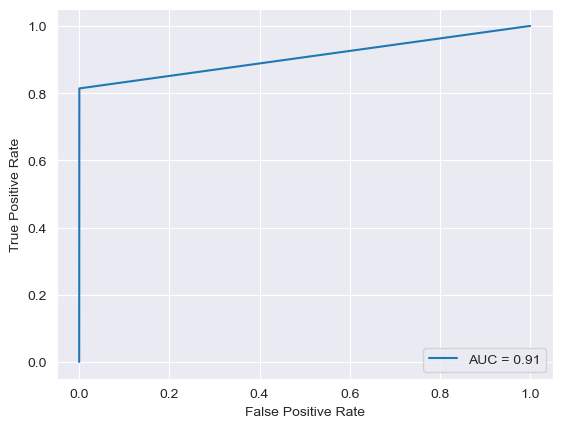

In [100]:
# Report the Confusion Matrix, ROC, and AUC for training and test sets.
confusion_mat_train = confusion_matrix(df_train["class"], y_pred_train)
print("Confusion Matrix - training:\n", confusion_mat_train)
fpr, tpr, _ = roc_curve(df_train["class"],  y_pred_train)
auc = roc_auc_score(df_train["class"], y_pred_train)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
display.plot()

Confusion Matrix - test
[[15600    25]
 [  115   260]]


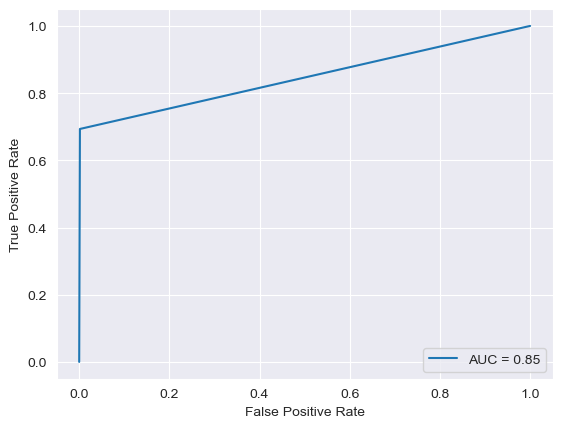

In [101]:
# confusion matrix - test
confusion_mat_test = confusion_matrix(df_test["class"], y_pred_test)
print("Confusion Matrix - test")
print(confusion_mat_test)
fpr, tpr, _ = roc_curve(df_test["class"], y_pred_test)
auc = roc_auc_score(df_test["class"], y_pred_test)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
display.plot()

### (f) Use SMOTE to pre-process your data

In [102]:
# Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.

a = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
pipeline = Pipeline([('smote', SMOTE()), ('xgb', xgb.XGBClassifier())])
params = {'xgb__reg_alpha': a}

# cv 5fold
xgbRegression_ = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
xgbRegression_.fit(df_train[df_train.columns[1:]], df_train["class"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interac...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10.0,
                                            100.0, 1000.0, 10000.0]})

In [103]:
# Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e

# train - similar to 1e
y_pred_train = xgbRegression_.predict(df_train[df_train.columns[1:]])
y_pred_train[y_pred_train > 0.5] = 1
y_pred_train[y_pred_train <= 0.5] = 0
print("train error:", np.sum(abs(y_pred_train - df_train["class"]))/len(df_train["class"]))


# test - eimilar to 1e
y_pred_test = xgbRegression_.predict(df_test[df_test.columns[1:]])
y_pred_test[y_pred_test > 0.5] = 1
y_pred_test[y_pred_test <= 0.5] = 0
print("test error:", np.sum(abs(y_pred_test - df_test["class"]))/len(df_test["class"]))

train error: 1.6666666666666667e-05
test error: 0.0173125


Confusion Matrix - training:
 [[59000     0]
 [    1   999]]


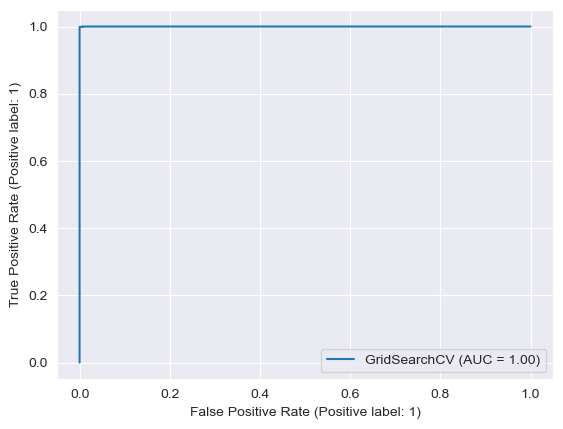

In [104]:
# confusion matrix - training
confusion_mat_train = confusion_matrix(df_train["class"], y_pred_train)
print("Confusion Matrix - training:\n", confusion_mat_train)
RocCurveDisplay.from_estimator(xgbRegression_, df_train[df_train.columns[1:]], df_train["class"])

In [105]:
# Confusion matrix - test
confusion_mat_test = confusion_matrix(df_test["class"], y_pred_test)
print("Confusion Matrix - test")
print(confusion_mat_test)
# RocCurveDisplay.from_estimator(xgbRegression_, df_test[df_test.columns[1:]], df_test["class"])

Confusion Matrix - test
[[15397   228]
 [   49   326]]


## 2. ISLR Questions

Please check PDF in the notebook folder for the theory questions